In [475]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from itertools import permutations
from itertools import product
from sklearn.metrics import confusion_matrix

In [476]:
with open('./pickles/newResa6.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/kmeans_total_6_c2.pickle', 'rb') as handle:
    kmeans_total3 = pickle.load(handle)

In [477]:
num_classi = 2

newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

In [478]:
def split_resa(k,resa):
    percentile_value = 1/k
    label = np.ndarray([resa.shape[0]],dtype=int)
    label[:] = int(-1)

    for i in range(0,k):
        label[(resa <= np.quantile(resa,q=(percentile_value*(i+1)))) & (resa >= np.quantile(resa,q=(percentile_value*i)))] = i

    return label


In [479]:
def removeTexts(xlim=np.Inf,ylim=np.Inf):
    axis = plt.gca()
    for text in axis.texts:
        if text.get_position()[0] > xlim or text.get_position()[1] > ylim: #check if x is more than 3
            text.remove()


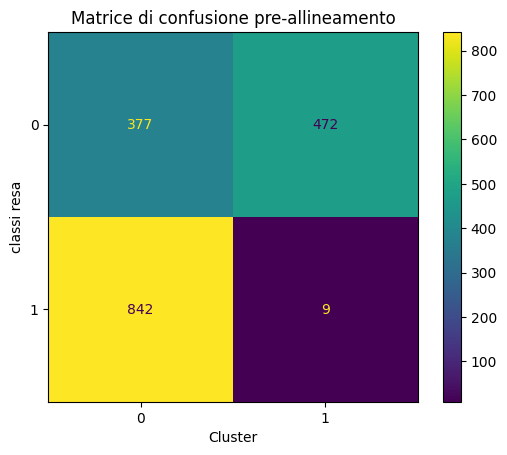

In [480]:
label = split_resa(num_classi,newResa3)

ConfusionMatrixDisplay.from_predictions(label,kmeans_total3[6,0])

removeTexts(xlim=1.5)
plt.xlabel('Cluster')
plt.ylabel('classi resa')
plt.xlim([-0.5,1.5])
plt.title('Matrice di confusione pre-allineamento')
plt.show()

In [481]:
print(list(product(np.unique(label),repeat=len(np.unique(kmeans_total3[6,0])))))
print(np.unique(label))
print(len(np.unique(kmeans_total3[6,0])))

[(0, 0), (0, 1), (1, 0), (1, 1)]
[0 1]
2


In [482]:
def best_cluster(matrice,cluster):
    a = np.arange(matrice.shape[0])
    permutation = list(product(np.unique(label),repeat=len(np.unique(cluster))))
    obiettivo = {'max': 0,
                'perm':[]}

    for perm in permutation:
        somma = 0
        for elem,index in zip(perm,range(matrice.shape[0])):
            somma += matrice[index,elem]
        if(somma > obiettivo['max']):
            obiettivo['max'] = somma
            obiettivo['perm'] = perm

    test_map = {}
    for pippo,pluto in zip(obiettivo['perm'],range(matrice.shape[0])):
        test_map[pluto] = pippo
    return test_map


In [483]:
cluster_class_mapping = {}
matrice_elementi = np.ndarray((len(np.unique(kmeans_total3[6,0])),num_classi))

for kmean in range(0,len(np.unique(kmeans_total3[6,0]))):

    cluster_classes = label[kmeans_total3[6,0] == kmean]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    
    matrice_elementi[kmean,:] = class_counts
    
cluster_class_mapping = best_cluster(matrice_elementi,kmeans_total3[6,0])

In [484]:
print(np.unique(kmeans_total3[6,0],return_counts=True))
print(cluster_class_mapping)

(array([0, 1], dtype=int64), array([1219,  481], dtype=int64))
{0: 1, 1: 0}


In [485]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
for i in range(len(np.unique(kmeans_total3[6,0]))):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [486]:
print(difference)

  num_cluster num_class
0           0         1
1           1         0


In [487]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(kmeans_total3[6,0]))
    if kmeans_total3[6,0][index] == a
])
for ind,true_value in zip(indici,difference['num_class']):
    kmeans_total3[6,0][ind] = true_value

In [488]:
cluster_class_mapping_test = {}
matrice_elementi = np.ndarray((len(np.unique(kmeans_total3[6,0])),num_classi))

for kmean,position in zip(np.unique(kmeans_total3[6,0]),range(len(np.unique(kmeans_total3[6,0])))):

    cluster_classes = label[kmeans_total3[6,0] == kmean]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    print(len(class_counts))
    matrice_elementi[position,:] = class_counts
    
cluster_class_mapping_test = best_cluster(matrice_elementi,kmeans_total3[6,0])

2
2


In [489]:
print(cluster_class_mapping_test)

{0: 0, 1: 1}


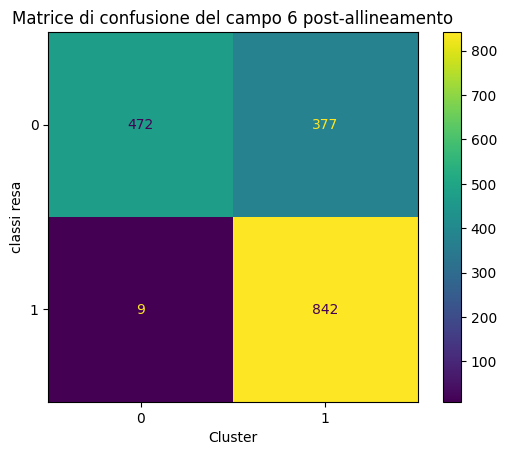

In [490]:
ConfusionMatrixDisplay.from_predictions(label,kmeans_total3[6,0])

removeTexts(xlim=num_classi)
plt.xlabel('Cluster')
plt.ylabel('classi resa')
plt.title('Matrice di confusione del campo 6 post-allineamento')
plt.show()

In [491]:
accuracy = str(accuracy_score(label,kmeans_total3[6,0]))
precision = str(precision_score(label,kmeans_total3[6,0],average= 'macro'))
recall = str(recall_score(label,kmeans_total3[6,0],average= 'macro'))

print("accuratezza " + accuracy)
print("precision " + precision)
print("recall " + recall)

accuratezza 0.7729411764705882
precision 0.8360095439668861
recall 0.7726861905691218


In [492]:
# Nuova matrice di confusione
confusion = confusion_matrix(label,kmeans_total3[6,0])
new_confusion = np.concatenate((confusion[:,0:1],confusion[:,2:3]),axis=1)
    

['−0.6', '−0.4', '−0.2', '0.0', '0.2', '0.4', '0.6']


C:\Users\pc\AppData\Local\Temp\ipykernel_11296\4089304289.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '0' , '','1'])


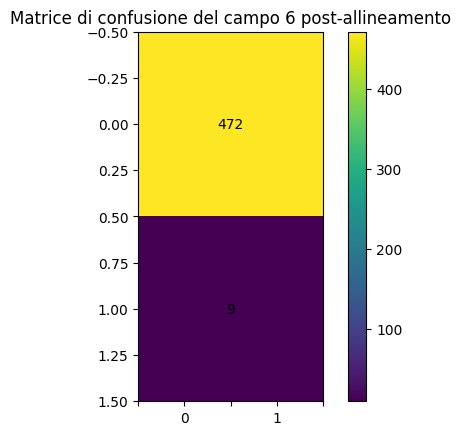

In [493]:
fig, ax = plt.subplots()
plt.rc('font', size=10)
image = ax.imshow(new_confusion[:,:])

for i in range(0,new_confusion.shape[0]):
    for j in range(0,new_confusion.shape[1]):
        c = np.round(new_confusion[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')

#fig.set_size_inches(15,25)
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
plt.colorbar(image)
plt.title('Matrice di confusione del campo 6 post-allineamento')
ax.set_xticklabels(['', '0' , '','1'])
plt.show()

In [496]:
accuracy_list = [0.7729411764705882, 0.59, 0.4588235294117647]
precision_list = [0.8360095439668861, 0.45803252612112333, 0.2713583780031688]
recall_list = [0.7726861905691218, 0.5896531452087007, 0.45706706981858164]

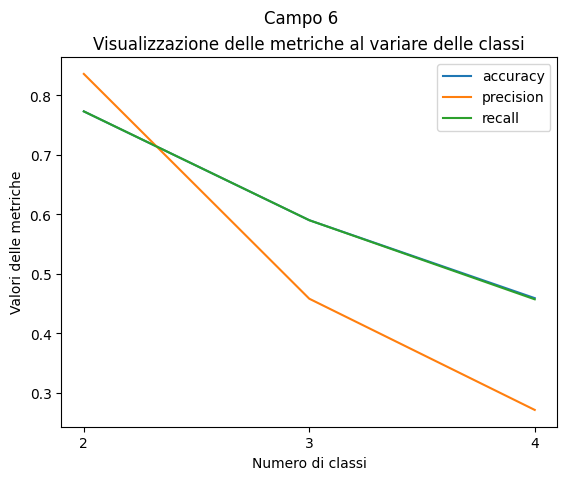

In [497]:
plt.plot(np.arange(2,5),np.around(accuracy_list,decimals=3),label='accuracy')
plt.plot(np.arange(2,5),np.around(precision_list,decimals=3),label='precision')
plt.plot(np.arange(2,5),np.around(recall_list,decimals=3),label='recall')
plt.title('Visualizzazione delle metriche al variare delle classi' )
plt.suptitle('Campo 6')
plt.xlabel('Numero di classi')
plt.ylabel('Valori delle metriche')
plt.xticks(np.arange(2,5))
plt.legend()